In [1]:
import botorch
import gpytorch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from utils.data_generation import GPData
from utils.training import fit_gp_model
from utils.plots import visualize_gp_belief_and_policy, visualize_progress_and_policy

/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exercises

### A.6.1 Extending TS to the batch setting via resampling

In [ ]:
# skipping this exercise since TS is implemented in the exercise below.

### A.6.2 Optimizing airplane designs

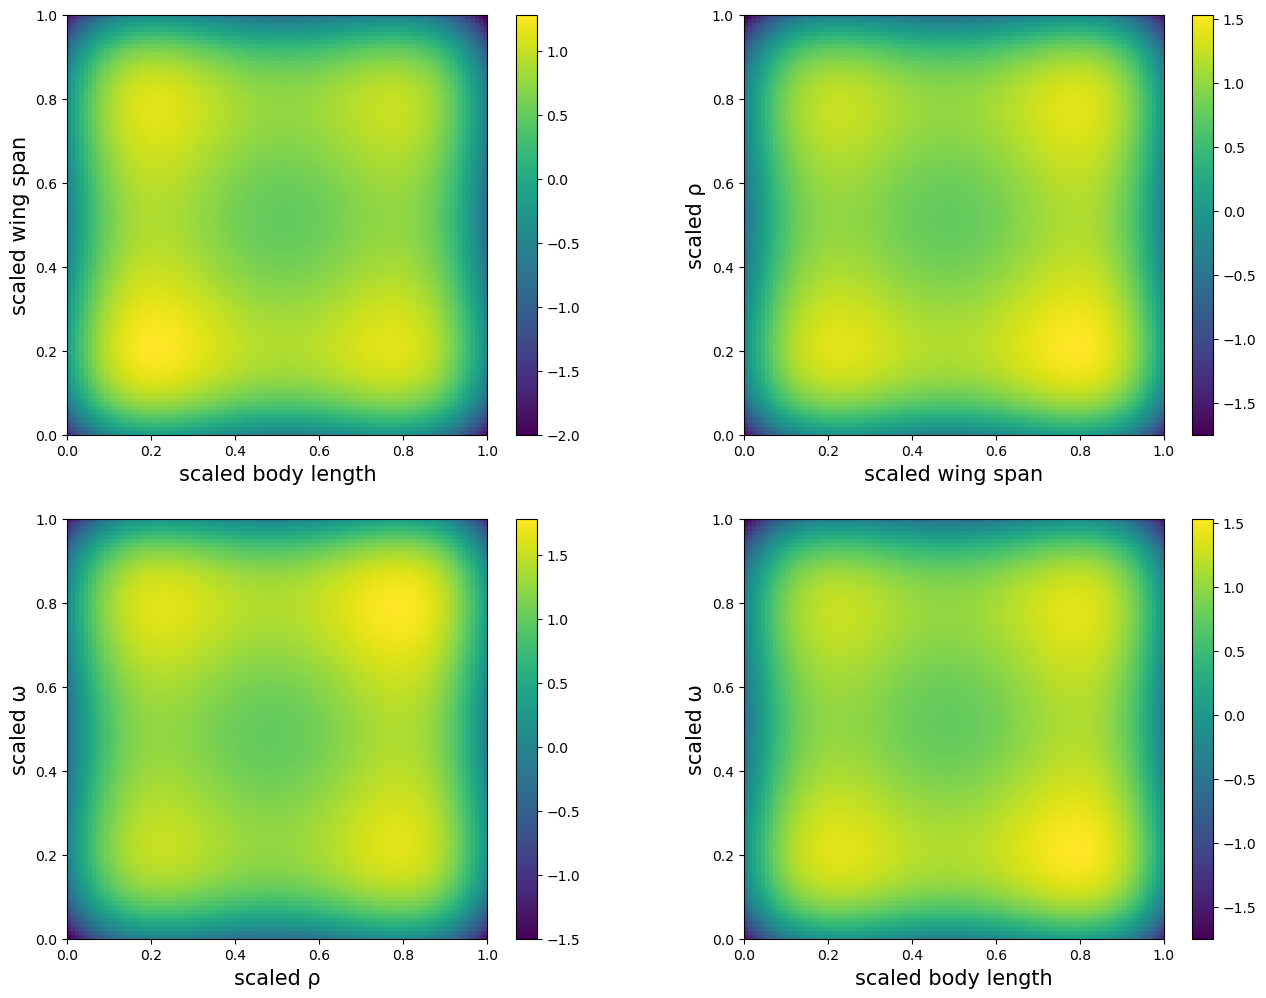

In [2]:
labels = ["scaled body length", "scaled wing span", "scaled ρ", "scaled ω"]


def visualize_objective(f):
    dimensions_to_plot = [(0, 1), (1, 2), (2, 3), (0, 3)]

    grid_x = torch.linspace(0, 1, 101)
    grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
    grid_x1 = grid_x1.flatten()
    grid_x2 = grid_x2.flatten()

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    for ax_ind, (i, j) in enumerate(dimensions_to_plot):
        tmp_ax = ax[ax_ind // 2][ax_ind % 2]

        xs = torch.zeros(101 ** 2, 4)
        xs[:, i] = grid_x1
        xs[:, j] = grid_x2

        c = tmp_ax.imshow(
            f(xs).reshape(101, 101),
            origin="lower",
            extent=[0, 1, 0, 1],
        )
        plt.colorbar(c, ax=tmp_ax)

        tmp_ax.set_xlabel(labels[i], fontsize=15)
        tmp_ax.set_ylabel(labels[j], fontsize=15)

    plt.show()


def flight_utility(X):
    X_copy = X.detach().clone()
    X_copy[:, [2, 3]] = 1 - X_copy[:, [2, 3]]
    X_copy = X_copy * 10 - 5

    return -0.005 * (X_copy ** 4 - 16 * X_copy ** 2 + 5 * X_copy).sum(dim=-1) + 3


visualize_objective(flight_utility)

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu=2.5, ard_num_dims=train_x.shape[-1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
lb, ub = 0, 1
bounds = torch.stack([lb * torch.ones(4), ub * torch.ones(4)])

train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 4)
train_y = flight_utility(train_x)

In [5]:
data = GPData(train_x, train_y)

In [6]:
num_experiments = 5
num_queries = 100
batch_size = 5
num_iters = num_queries // batch_size
k = 100
num_candidates = 5000
incumbents = torch.zeros((num_experiments, num_iters))
pbar = tqdm(total=num_experiments * num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
strategy = "mes"  # "poi", "ei", "ucb", "ts", or "mes"
strategy = strategy.upper()

for exp in range(num_experiments):
    torch.manual_seed(exp)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 4)
    train_y = flight_utility(train_x)

    for i in range(num_iters):
        incumbents[exp, i] = train_y.max()

        model, likelihood = fit_gp_model(train_x, train_y)

        if strategy == "POI":
            policy = botorch.acquisition.monte_carlo.qProbabilityOfImprovement(
                model, best_f=train_y.max()
            )

        if strategy == "EI":
            policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
                model, best_f=train_y.max()
            )

        if strategy == "UCB":
            policy = botorch.acquisition.monte_carlo.qUpperConfidenceBound(
                model, beta=2
            )

        if strategy in ["POI", "EI", "UCB"]:
            next_x, acq_val = botorch.optim.optimize_acqf(
                policy,
                bounds=bounds,
                q=batch_size,
                num_restarts=100,
                raw_samples=200,
            )
        else:
            sobol = torch.quasirandom.SobolEngine(4, scramble=True)
            candidate_x = sobol.draw(num_candidates)
            candidate_x = (bounds[1] - bounds[0]) * candidate_x + bounds[0]

            if strategy == "TS":
                ts = botorch.generation.MaxPosteriorSampling(model, replacement=False)
                next_x = ts(candidate_x, num_samples=batch_size)

            if strategy == "MES":
                policy = botorch.acquisition.max_value_entropy_search.qMaxValueEntropy(
                    model, candidate_x
                )
                next_x, acq_val = botorch.optim.optimize_acqf_cyclic(
                    policy,
                    bounds=bounds,
                    q=batch_size,
                    num_restarts=40,
                    raw_samples=100,
                    cyclic_options={"maxiter": 5},
                )

        next_y = flight_utility(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

        pbar.update()